In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
mpl.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置

In [2]:
path = 'F:\\Code\\jupyter_notebook\\超导体\\Dataset\\train.csv'
path1 = 'F:\\Code\\jupyter_notebook\\超导体\\Dataset\\unique_m.csv'
dataSet1 = pd.read_csv(path)
dataSet2 = pd.read_csv(path1).drop(['critical_temp', 'material'], axis = 1)

dataFrame = pd.concat([dataSet1, dataSet2], axis = 1)

dataFrame.head(5)

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [3]:
# 删除一切相关联的特征,进行抽象
correlationMatrix = dataFrame.corr()
correlationFeatures = set()

for i in range(len(correlationMatrix)) :
    for j in range(i) :
        if abs(correlationMatrix.iloc[i, j]) > 0.75 :
            colname = correlationMatrix.columns[i]
            if colname != "critical_temp" :
                correlationFeatures.add(colname)
dataFrame.drop(correlationFeatures, axis = 1, inplace = True)
dataFrame.shape

(21263, 108)

In [4]:
# 把方差低的特征剔除
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold = 0.1)
selector.fit(dataFrame)
dataFrame = pd.DataFrame(selector.transform(dataFrame), columns = dataFrame.columns[selector.get_support()])
dataFrame.shape


(21263, 63)

In [5]:
dataFrame.to_csv('CleanData.csv')

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

df = pd.read_csv('CleanData.csv')
x = df.drop('critical_temp', axis = 1)
x_scale = sc.fit_transform(x)
x = pd.DataFrame(x_scale, columns = x.columns)
y = df['critical_temp']

e=0.1515151515151516
intercept = 1.5542
# y_t = y.apply(lambda x: (x**e)-intercept)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)
# x_train, x_test, y_train, y_test = train_test_split(x, y_t, test_size = 0.25, random_state = 42)

y_train

617      105.00
7070      13.50
1310      69.30
1012      38.00
15180     17.00
          ...  
11284      1.50
11964      5.82
5390      60.00
860       15.00
15795      0.70
Name: critical_temp, Length: 15947, dtype: float64

In [7]:
# 改变树的数量后观察模型的灵敏度
forest = RandomForestRegressor(n_estimators=200, max_features='log2')
forest.fit(x_train, y_train)

y_prediction = pd.Series(forest.predict(x_test))
y_prediction_train = pd.Series(forest.predict(x_train))

# y_test = y_test.apply(lambda x: (x+intercept)**(1/e))
# y_train = y_train.apply(lambda x: (x+intercept)**(1/e))


# y_prediction = pd.Series(forest.predict(x_test)).apply(lambda x: (x+intercept)**(1/e))
# y_pred_train = pd.Series(rf.predict(X_train)).apply(lambda x: (x+intercept)**(1/e))

# # 评价
# # 4是四位有效数字
# min_rmse = round(np.sqrt(mean_squared_error(y_test, y_prediction)), 4)
# r2 = round(r2_score(y_prediction, y_test), 4)

# print(r2)
# print(min_rmse)
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

MAE_LR = metrics.mean_absolute_error(y_test, y_prediction)
SQRT_LR = np.sqrt(metrics.mean_squared_error(y_test, y_prediction))
VARIENCE_LR = explained_variance_score(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)
# CC_LR=correlationCoefficient(y_test, y_pred,len(y_test) )

print('Root Mean Squared Error:',SQRT_LR )
print('Mean Absolute Error:', MAE_LR)
print ('r2:',r2)
print('model score:', forest.score(x_train, y_train))

Root Mean Squared Error: 9.007925696817288
Mean Absolute Error: 5.042689150933371
r2: 0.9298292324889653
model score: 0.9899061727442358


Feature ranking:
1. Cu (0.109931)
2. O (0.080226)
3. range_ThermalConductivity (0.076280)
4. Unnamed: 0 (0.069468)
5. Ba (0.066840)
6. wtd_mean_ThermalConductivity (0.045836)
7. Ca (0.041004)
8. wtd_range_Valence (0.037026)
9. wtd_mean_fie (0.034329)
10. number_of_elements (0.034063)
11. range_ElectronAffinity (0.031150)
12. gmean_ThermalConductivity (0.030460)
13. mean_ThermalConductivity (0.028702)
14. wtd_range_fie (0.028132)
15. mean_FusionHeat (0.026351)
16. range_atomic_mass (0.025671)
17. range_Density (0.025466)
18. wtd_range_atomic_mass (0.025006)
19. wtd_mean_ElectronAffinity (0.023640)
20. wtd_range_atomic_radius (0.019491)
21. mean_ElectronAffinity (0.019290)
22. entropy_ThermalConductivity (0.014419)
23. mean_fie (0.013755)
24. mean_atomic_radius (0.012588)
25. mean_atomic_mass (0.011763)
26. range_FusionHeat (0.009559)
27. Sr (0.009387)
28. La (0.009136)
29. Y (0.007067)
30. range_Valence (0.006880)
31. Pr (0.005692)
32. Fe (0.003797)
33. Bi (0.003491)
34. Zn (0.003125)
3

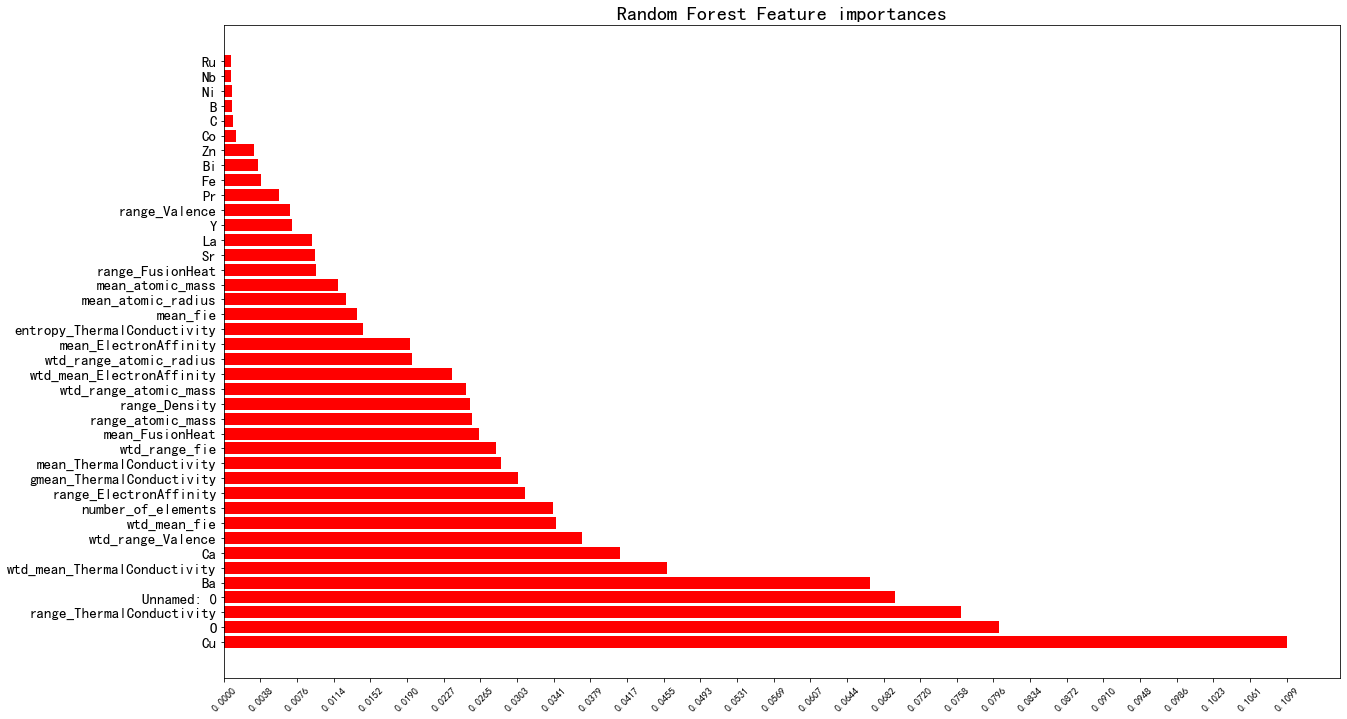

In [8]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
feature_importances = []
for f in range(x.shape[1]):
    if f == 40 : break
    print("%d. %s (%f)" % (f + 1, x.columns[indices[f]], importances[indices[f]]))
    feature_importances.append((x.columns[indices[f]],importances[indices[f]]))
    
# Print the feature ranking

values = [i[1] for i in feature_importances]
names = [i[0] for i in feature_importances]

# Plot the feature importances of the forest
plt.figure(figsize=(20,12))
plt.title("Random Forest Feature importances",fontsize=20)
plt.barh(range(len(names)),values, color="r", align='center') #, yerr=std[indices], align="center")
plt.yticks(range(len(names)),names,fontsize=15)
plt.xticks(np.linspace(0,max(importances),30),rotation=45)
plt.savefig('photos/regression/RF_feature_importance.png')
plt.show()


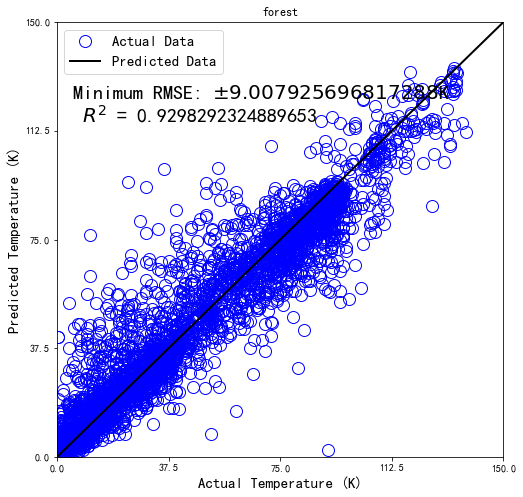

In [9]:
plt.figure(1, figsize=(8, 8))
plt.plot(y_test, y_prediction, 'bo', markersize = 12, mfc = 'none')
plt.plot([0, 150], [0, 150], 'k', linewidth = 2)
plt.xlabel('Actual Temperature (K)', fontsize = 15)
plt.ylabel('Predicted Temperature (K)', fontsize = 15)
plt.xlim((0, 150))
plt.ylim((0, 150))
ticks = np.linspace(0, 150, 5)
text = r'$\pm' + str(SQRT_LR) + '$' + 'K \n $R^2$ = ' + str(r2)
plt.text(5, 115, 'Minimum RMSE: ' + text, fontsize = 20)
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('forest')
plt.legend(['Actual Data', 'Predicted Data'], loc = 'best', fontsize = 15)
plt.savefig('photos/regression/forest.png')
plt.show()

c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


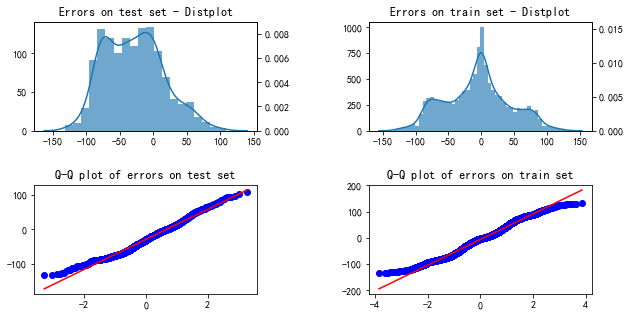

In [10]:
import seaborn as sns
from scipy.stats import norm
from scipy import stats


errors_test = (y_prediction - y_test).dropna()
errors_train = (y_prediction_train - y_train).dropna()

plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.title('Errors on test set - Distplot')
ax_test = sns.distplot(errors_test, kde=False)
second_ax1 = ax_test.twinx()
sns.distplot(errors_test, ax=second_ax1, kde=True, hist=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,2)
plt.title('Errors on train set - Distplot')
ax_train = sns.distplot(errors_train, kde=False)
second_ax2 = ax_train.twinx()
sns.distplot(errors_train, ax=second_ax2, kde=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,3)
res = stats.probplot(errors_test, plot=plt)
plt.title('Q-Q plot of errors on test set')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,4)
res = stats.probplot(errors_train, plot=plt)
plt.title('Q-Q plot of errors on train set')
plt.xlabel('')
plt.ylabel('')
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.savefig('photos/regression/forest_Errors_distplot.png')
plt.show()

In [11]:
# 线性回归
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)
y_prediction = pd.Series(reg.predict(x_test))
y_prediction_train = pd.Series(reg.predict(x_train))
# y_test = y_test.apply(lambda x: (x+intercept)**(1/e))
# y_train = y_train.apply(lambda x: (x+intercept)**(1/e))


# y_prediction = pd.Series(forest.predict(x_test)).apply(lambda x: (x+intercept)**(1/e))

# 评价
MAE_LR = metrics.mean_absolute_error(y_test, y_prediction)
SQRT_LR = np.sqrt(metrics.mean_squared_error(y_test, y_prediction))
VARIENCE_LR = explained_variance_score(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)
# CC_LR=correlationCoefficient(y_test, y_pred,len(y_test) )

print('Root Mean Squared Error:',SQRT_LR )
print('Mean Absolute Error:', MAE_LR)  
print ('r2:',r2)
print('model score:', forest.score(x_train, y_train))

Root Mean Squared Error: 18.579356048937388
Mean Absolute Error: 14.009040919163672
r2: 0.7014837678254522
model score: 0.9899061727442358


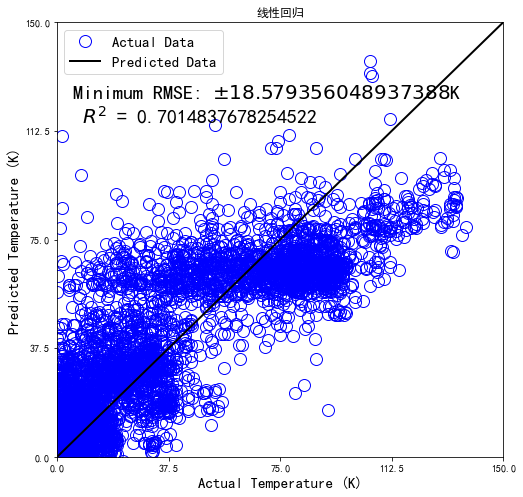

In [12]:
plt.figure(1, figsize=(8, 8))
plt.plot(y_test, y_prediction, 'bo', markersize = 12, mfc = 'none')
plt.plot([0, 150], [0, 150], 'k', linewidth = 2)
plt.xlabel('Actual Temperature (K)', fontsize = 15)
plt.ylabel('Predicted Temperature (K)', fontsize = 15)
plt.xlim((0, 150))
plt.ylim((0, 150))
ticks = np.linspace(0, 150, 5)
text = r'$\pm' + str(SQRT_LR) + '$' + 'K \n $R^2$ = ' + str(r2)
plt.text(5, 115, 'Minimum RMSE: ' + text, fontsize = 20)
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('LinearRegression')
plt.legend(['Actual Data', 'Predicted Data'], loc = 'best', fontsize = 15)
plt.savefig('photos/regression/lr.png')
plt.show()

c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


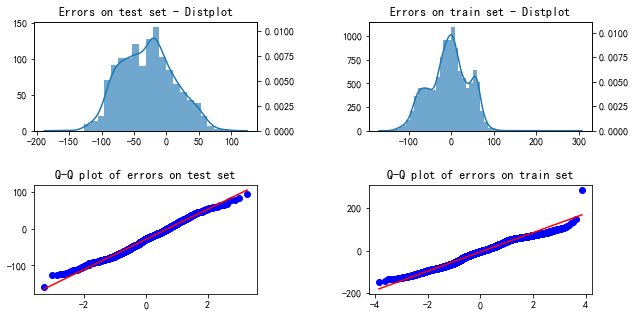

In [13]:
import seaborn as sns
from scipy.stats import norm
from scipy import stats


errors_test = (y_prediction - y_test).dropna()
errors_train = (y_prediction_train - y_train).dropna()

plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.title('Errors on test set - Distplot')
ax_test = sns.distplot(errors_test, kde=False)
second_ax1 = ax_test.twinx()
sns.distplot(errors_test, ax=second_ax1, kde=True, hist=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,2)
plt.title('Errors on train set - Distplot')
ax_train = sns.distplot(errors_train, kde=False)
second_ax2 = ax_train.twinx()
sns.distplot(errors_train, ax=second_ax2, kde=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,3)
res = stats.probplot(errors_test, plot=plt)
plt.title('Q-Q plot of errors on test set')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,4)
res = stats.probplot(errors_train, plot=plt)
plt.title('Q-Q plot of errors on train set')
plt.xlabel('')
plt.ylabel('')
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.savefig('photos/regression/lr_Errors_distplot.png')
plt.show()

In [14]:
# Knearest Neighbors
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
n_neighbors = 5
knn = neighbors.KNeighborsRegressor(n_neighbors, weights = 'distance')

knn.fit(x_train, y_train)
y_prediction = pd.Series(knn.predict(x_test))
y_prediction_train = pd.Series(knn.predict(x_train))
# y_test = y_test.apply(lambda x: (x+intercept)**(1/e))
# y_train = y_train.apply(lambda x: (x+intercept)**(1/e))


# y_prediction = pd.Series(forest.predict(x_test)).apply(lambda x: (x+intercept)**(1/e))

MAE_LR = metrics.mean_absolute_error(y_test, y_prediction)
SQRT_LR = np.sqrt(metrics.mean_squared_error(y_test, y_prediction))
VARIENCE_LR = explained_variance_score(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)
# CC_LR=correlationCoefficient(y_test, y_pred,len(y_test) )

print('Root Mean Squared Error:',SQRT_LR )
print('Mean Absolute Error:', MAE_LR)  
print ('r2:',r2)
print('model score:', forest.score(x_train, y_train))

Root Mean Squared Error: 9.873668199693089
Mean Absolute Error: 5.392840746626396
r2: 0.9156929886308416
model score: 0.9899061727442358


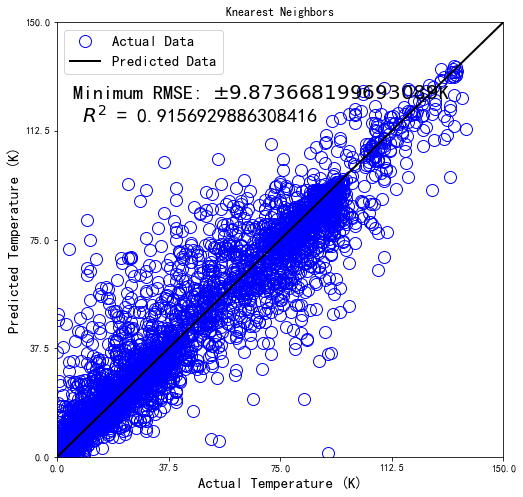

In [15]:
plt.figure(1, figsize=(8, 8))
plt.plot(y_test, y_prediction, 'bo', markersize = 12, mfc = 'none')
plt.plot([0, 150], [0, 150], 'k', linewidth = 2)
plt.xlabel('Actual Temperature (K)', fontsize = 15)
plt.ylabel('Predicted Temperature (K)', fontsize = 15)
plt.xlim((0, 150))
plt.ylim((0, 150))
ticks = np.linspace(0, 150, 5)
text = r'$\pm' + str(SQRT_LR) + '$' + 'K \n $R^2$ = ' + str(r2)
plt.text(5, 115, 'Minimum RMSE: ' + text, fontsize = 20)
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('Knearest Neighbors')
plt.legend(['Actual Data', 'Predicted Data'], loc = 'best', fontsize = 15)
plt.savefig('photos/regression/knearest_neighbors.png')
plt.show()

c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


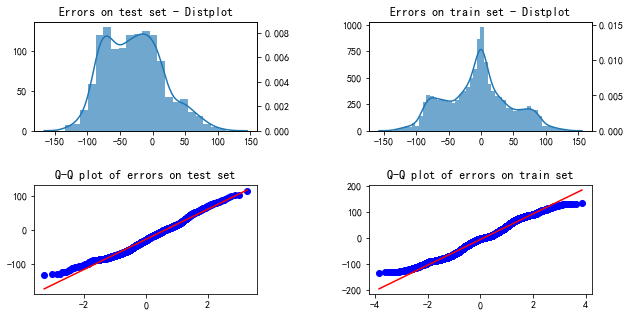

In [16]:
import seaborn as sns
from scipy.stats import norm
from scipy import stats


errors_test = (y_prediction - y_test).dropna()
errors_train = (y_prediction_train - y_train).dropna()

plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.title('Errors on test set - Distplot')
ax_test = sns.distplot(errors_test, kde=False)
second_ax1 = ax_test.twinx()
sns.distplot(errors_test, ax=second_ax1, kde=True, hist=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,2)
plt.title('Errors on train set - Distplot')
ax_train = sns.distplot(errors_train, kde=False)
second_ax2 = ax_train.twinx()
sns.distplot(errors_train, ax=second_ax2, kde=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,3)
res = stats.probplot(errors_test, plot=plt)
plt.title('Q-Q plot of errors on test set')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,4)
res = stats.probplot(errors_train, plot=plt)
plt.title('Q-Q plot of errors on train set')
plt.xlabel('')
plt.ylabel('')
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.savefig('photos/regression/k_N_Errors_distplot.png')
plt.show()

In [17]:
# 决策树
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=42)
tree.fit(x_train, y_train)

y_prediction = pd.Series(tree.predict(x_test))
y_prediction_train = pd.Series(tree.predict(x_train))
# y_test = y_test.apply(lambda x: (x+intercept)**(1/e))
# y_train = y_train.apply(lambda x: (x+intercept)**(1/e))


# y_prediction = pd.Series(forest.predict(x_test)).apply(lambda x: (x+intercept)**(1/e))

MAE_LR = metrics.mean_absolute_error(y_test, y_prediction)
SQRT_LR = np.sqrt(metrics.mean_squared_error(y_test, y_prediction))
VARIENCE_LR = explained_variance_score(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)
# CC_LR=correlationCoefficient(y_test, y_pred,len(y_test) )

print('Root Mean Squared Error:',SQRT_LR )
print('Mean Absolute Error:', MAE_LR)  
print ('r2:',r2)
print('model score:', forest.score(x_train, y_train))

Root Mean Squared Error: 11.98729188439662
Mean Absolute Error: 6.088065110045147
r2: 0.8757350077677235
model score: 0.9899061727442358


Feature ranking:
1. Cu (0.607891)
2. Ca (0.059297)
3. Ba (0.051858)
4. O (0.046257)
5. Unnamed: 0 (0.024453)
6. wtd_mean_ThermalConductivity (0.014920)
7. range_FusionHeat (0.014161)
8. Pr (0.012801)
9. wtd_mean_ElectronAffinity (0.012417)
10. wtd_range_atomic_radius (0.012391)
11. mean_atomic_mass (0.011648)
12. wtd_range_Valence (0.011346)
13. wtd_mean_fie (0.010291)
14. Zn (0.009853)
15. wtd_range_fie (0.009319)
16. wtd_range_atomic_mass (0.009020)
17. Fe (0.008831)
18. mean_atomic_radius (0.007417)
19. entropy_ThermalConductivity (0.006138)
20. mean_ThermalConductivity (0.005747)
21. range_Density (0.005076)
22. mean_fie (0.004438)
23. mean_FusionHeat (0.004307)
24. range_ThermalConductivity (0.003943)
25. range_Valence (0.003940)
26. La (0.003399)
27. mean_ElectronAffinity (0.003310)
28. gmean_ThermalConductivity (0.003240)
29. Co (0.003033)
30. range_atomic_mass (0.003019)
31. Sr (0.002740)
32. number_of_elements (0.002066)
33. range_ElectronAffinity (0.001979)
34. Bi (0.001932)


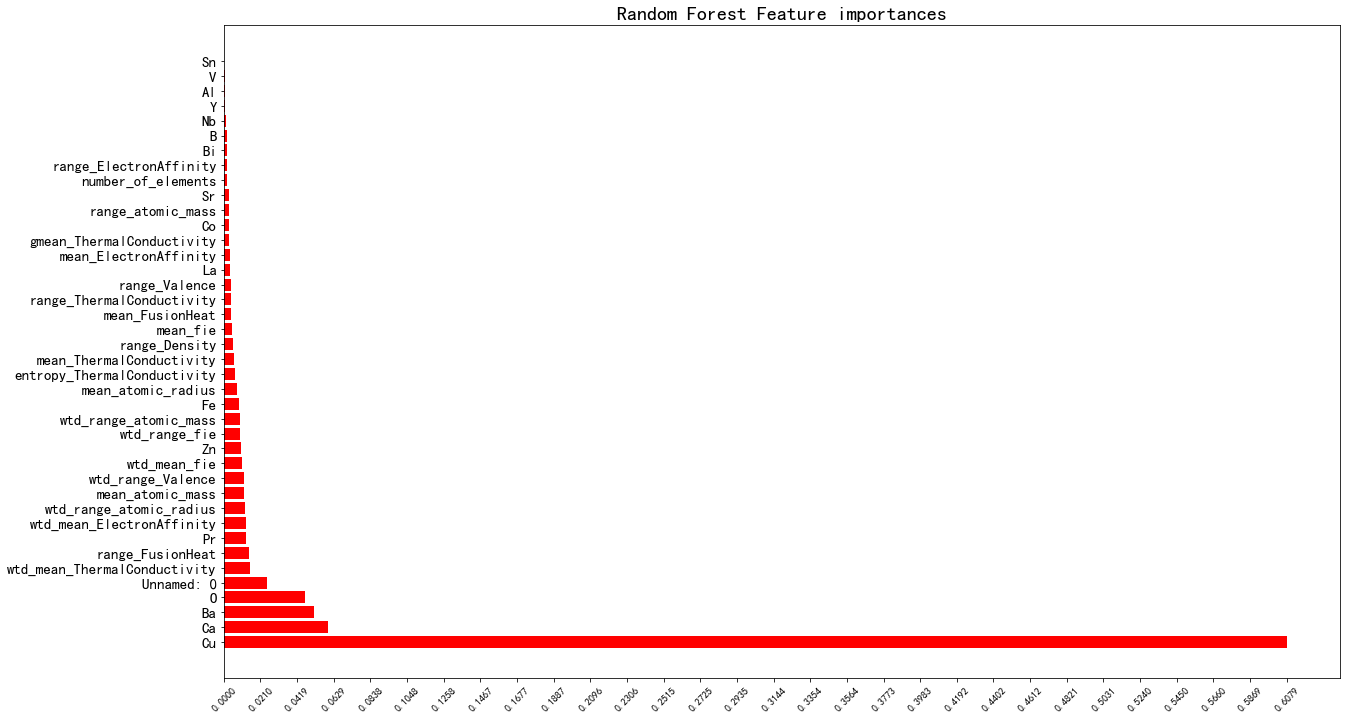

In [18]:
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
feature_importances = []
for f in range(x.shape[1]):
    if f == 40 : break
    print("%d. %s (%f)" % (f + 1, x.columns[indices[f]], importances[indices[f]]))
    feature_importances.append((x.columns[indices[f]],importances[indices[f]]))
    
# Print the feature ranking

values = [i[1] for i in feature_importances]
names = [i[0] for i in feature_importances]

# Plot the feature importances of the forest
plt.figure(figsize=(20,12))
plt.title("Random Forest Feature importances",fontsize=20)
plt.barh(range(len(names)),values, color="r", align='center') #, yerr=std[indices], align="center")
plt.yticks(range(len(names)),names,fontsize=15)
plt.xticks(np.linspace(0,max(importances),30),rotation=45)
plt.savefig('photos/regression/tree_feature_importance.png')
plt.show()


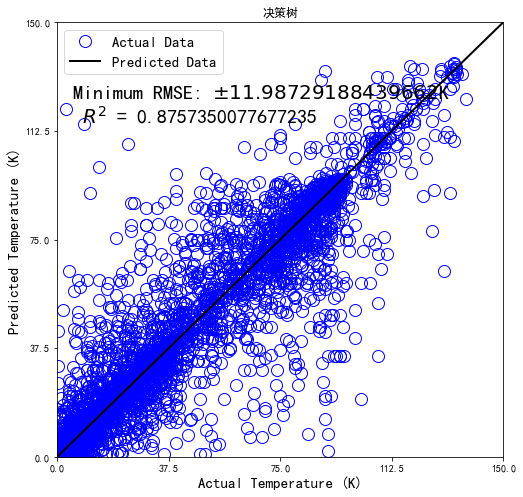

In [19]:
plt.figure(1, figsize=(8, 8))
plt.plot(y_test, y_prediction, 'bo', markersize = 12, mfc = 'none')
plt.plot([0, 150], [0, 150], 'k', linewidth = 2)
plt.xlabel('Actual Temperature (K)', fontsize = 15)
plt.ylabel('Predicted Temperature (K)', fontsize = 15)
plt.xlim((0, 150))
plt.ylim((0, 150))
ticks = np.linspace(0, 150, 5)
text = r'$\pm' + str(SQRT_LR) + '$' + 'K \n $R^2$ = ' + str(r2)
plt.text(5, 115, 'Minimum RMSE: ' + text, fontsize = 20)
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('决策树')
plt.legend(['Actual Data', 'Predicted Data'], loc = 'best', fontsize = 15)

plt.savefig('photos/regression/tree.png')
plt.show()

c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


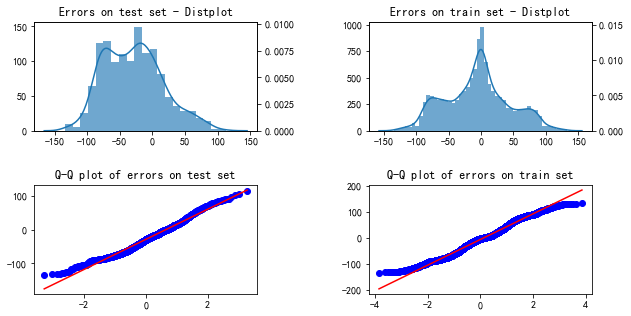

In [20]:
import seaborn as sns
from scipy.stats import norm
from scipy import stats


errors_test = (y_prediction - y_test).dropna()
errors_train = (y_prediction_train - y_train).dropna()

plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.title('Errors on test set - Distplot')
ax_test = sns.distplot(errors_test, kde=False)
second_ax1 = ax_test.twinx()
sns.distplot(errors_test, ax=second_ax1, kde=True, hist=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,2)
plt.title('Errors on train set - Distplot')
ax_train = sns.distplot(errors_train, kde=False)
second_ax2 = ax_train.twinx()
sns.distplot(errors_train, ax=second_ax2, kde=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,3)
res = stats.probplot(errors_test, plot=plt)
plt.title('Q-Q plot of errors on test set')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,4)
res = stats.probplot(errors_train, plot=plt)
plt.title('Q-Q plot of errors on train set')
plt.xlabel('')
plt.ylabel('')
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.savefig('photos/regression/tree_Errors_distplot.png')
plt.show()

In [21]:
# GBDT
# 梯度增强
from sklearn.ensemble import GradientBoostingRegressor
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = 42)
GBoost.fit(x_train, y_train)
y_prediction = pd.Series(GBoost.predict(x_test))
y_prediction_train = pd.Series(GBoost.predict(x_train))

MAE_LR = metrics.mean_absolute_error(y_test, y_prediction)
SQRT_LR = np.sqrt(metrics.mean_squared_error(y_test, y_prediction))
VARIENCE_LR = explained_variance_score(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)
# CC_LR=correlationCoefficient(y_test, y_pred,len(y_test) )

print('Root Mean Squared Error:',SQRT_LR )
print('Mean Absolute Error:', MAE_LR)  
print ('r2:',r2)
print('model score:', forest.score(x_train, y_train))

Root Mean Squared Error: 9.799811012205867
Mean Absolute Error: 5.626590253529826
r2: 0.9169495409401721
model score: 0.9899061727442358


Feature ranking:
1. Cu (0.171956)
2. range_ThermalConductivity (0.126938)
3. O (0.105423)
4. number_of_elements (0.050704)
5. wtd_mean_fie (0.050537)
6. Unnamed: 0 (0.046259)
7. Ba (0.044534)
8. Ca (0.039808)
9. wtd_range_Valence (0.037372)
10. range_Density (0.027512)
11. range_atomic_mass (0.025999)
12. wtd_mean_ThermalConductivity (0.022754)
13. wtd_mean_ElectronAffinity (0.022567)
14. mean_ThermalConductivity (0.021741)
15. wtd_range_fie (0.021651)
16. mean_FusionHeat (0.018644)
17. range_ElectronAffinity (0.016375)
18. mean_ElectronAffinity (0.013297)
19. range_FusionHeat (0.012733)
20. Pr (0.012693)
21. gmean_ThermalConductivity (0.010507)
22. wtd_range_atomic_mass (0.010297)
23. mean_atomic_radius (0.008772)
24. Fe (0.008177)
25. Zn (0.007532)
26. La (0.007390)
27. mean_atomic_mass (0.007292)
28. mean_fie (0.006903)
29. Sr (0.006857)
30. range_Valence (0.006697)
31. entropy_ThermalConductivity (0.006481)
32. Y (0.006198)
33. wtd_range_atomic_radius (0.005428)
34. Bi (0.002434)
3

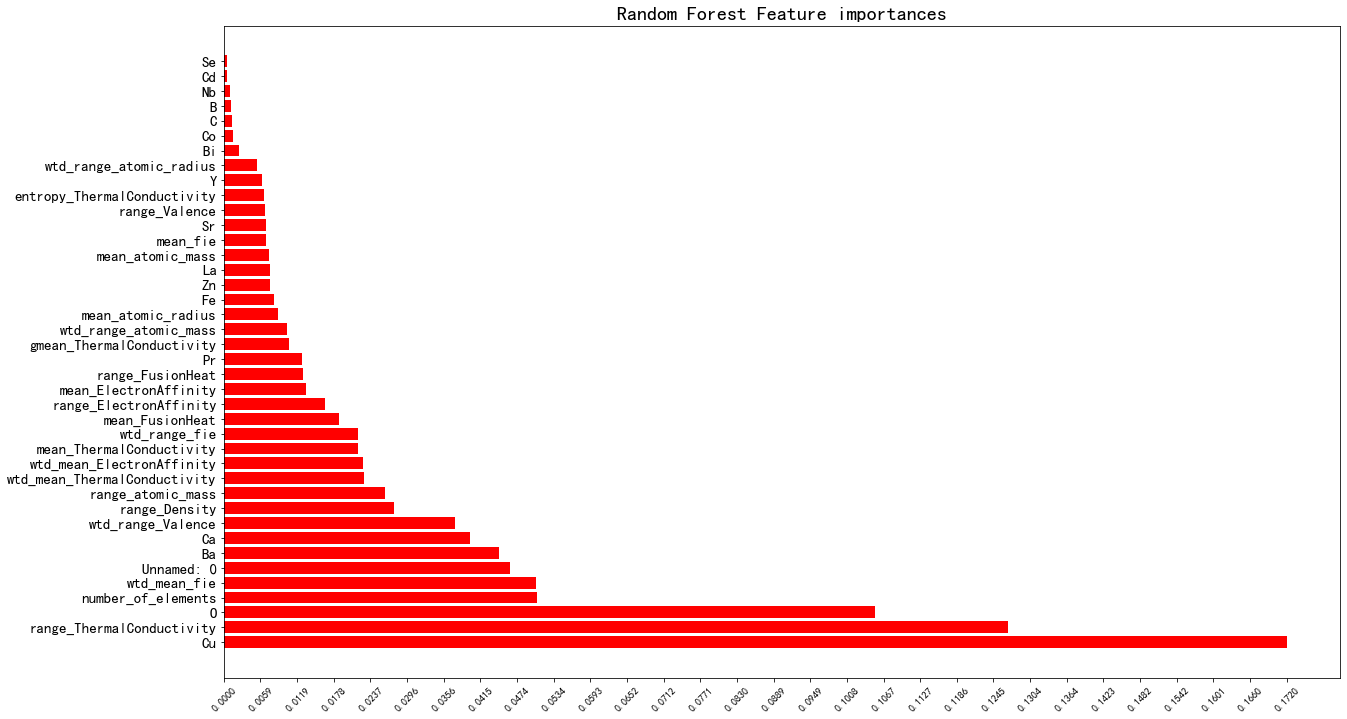

In [22]:
importances = GBoost.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
feature_importances = []
for f in range(x.shape[1]):
    if f == 40 : break
    print("%d. %s (%f)" % (f + 1, x.columns[indices[f]], importances[indices[f]]))
    feature_importances.append((x.columns[indices[f]],importances[indices[f]]))
    
# Print the feature ranking

values = [i[1] for i in feature_importances]
names = [i[0] for i in feature_importances]

# Plot the feature importances of the forest
plt.figure(figsize=(20,12))
plt.title("Random Forest Feature importances",fontsize=20)
plt.barh(range(len(names)),values, color="r", align='center') #, yerr=std[indices], align="center")
plt.yticks(range(len(names)),names,fontsize=15)
plt.xticks(np.linspace(0,max(importances),30),rotation=45)
plt.savefig('GBoost_feature_importance.png')
plt.show()


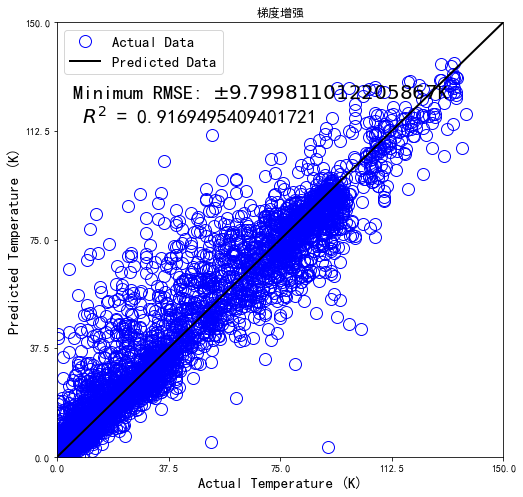

In [23]:
plt.figure(1, figsize=(8, 8))
plt.plot(y_test, y_prediction, 'bo', markersize = 12, mfc = 'none')
plt.plot([0, 150], [0, 150], 'k', linewidth = 2)
plt.xlabel('Actual Temperature (K)', fontsize = 15)
plt.ylabel('Predicted Temperature (K)', fontsize = 15)
plt.xlim((0, 150))
plt.ylim((0, 150))
ticks = np.linspace(0, 150, 5)
text = r'$\pm' + str(SQRT_LR) + '$' + 'K \n $R^2$ = ' + str(r2)
plt.text(5, 115, 'Minimum RMSE: ' + text, fontsize = 20)
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('梯度增强')
plt.legend(['Actual Data', 'Predicted Data'], loc = 'best', fontsize = 15)

plt.savefig('photos/regression/GBoost.png')
plt.show()

c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


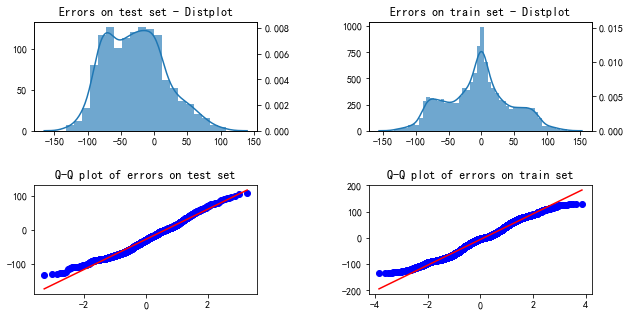

In [24]:
import seaborn as sns
from scipy.stats import norm
from scipy import stats


errors_test = (y_prediction - y_test).dropna()
errors_train = (y_prediction_train - y_train).dropna()

plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.title('Errors on test set - Distplot')
ax_test = sns.distplot(errors_test, kde=False)
second_ax1 = ax_test.twinx()
sns.distplot(errors_test, ax=second_ax1, kde=True, hist=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,2)
plt.title('Errors on train set - Distplot')
ax_train = sns.distplot(errors_train, kde=False)
second_ax2 = ax_train.twinx()
sns.distplot(errors_train, ax=second_ax2, kde=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,3)
res = stats.probplot(errors_test, plot=plt)
plt.title('Q-Q plot of errors on test set')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,4)
res = stats.probplot(errors_train, plot=plt)
plt.title('Q-Q plot of errors on train set')
plt.xlabel('')
plt.ylabel('')
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.savefig('GBoost_Errors_distplot.png')
plt.show()

In [25]:
# AdaBoost

from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(base_estimator=tree, n_estimators=200,
                        learning_rate=0.8)
ada.fit(x_train, y_train)

y_prediction = pd.Series(ada.predict(x_test))
y_prediction_train = pd.Series(ada.predict(x_train))

MAE_LR = metrics.mean_absolute_error(y_test, y_prediction)
SQRT_LR = np.sqrt(metrics.mean_squared_error(y_test, y_prediction))
VARIENCE_LR = explained_variance_score(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)
# CC_LR=correlationCoefficient(y_test, y_pred,len(y_test) )

print('Root Mean Squared Error:',SQRT_LR )
print('Mean Absolute Error:', MAE_LR)  
print ('r2:',r2)
print('model score:', forest.score(x_train, y_train))

Root Mean Squared Error: 9.346698573600277
Mean Absolute Error: 4.796596982693755
r2: 0.9244519758163414
model score: 0.9899061727442358


Feature ranking:
1. Cu (0.334554)
2. Ca (0.095446)
3. Ba (0.085633)
4. Unnamed: 0 (0.063128)
5. wtd_mean_ThermalConductivity (0.036964)
6. wtd_mean_ElectronAffinity (0.026561)
7. wtd_mean_fie (0.026263)
8. O (0.025780)
9. wtd_range_atomic_mass (0.023291)
10. wtd_range_Valence (0.021472)
11. wtd_range_fie (0.020348)
12. wtd_range_atomic_radius (0.017947)
13. mean_ThermalConductivity (0.015651)
14. mean_atomic_mass (0.015213)
15. mean_FusionHeat (0.014196)
16. mean_fie (0.013160)
17. Pr (0.013158)
18. mean_atomic_radius (0.012485)
19. Sr (0.012382)
20. La (0.012067)
21. range_atomic_mass (0.011863)
22. entropy_ThermalConductivity (0.010919)
23. range_Density (0.010847)
24. Zn (0.009526)
25. mean_ElectronAffinity (0.008628)
26. gmean_ThermalConductivity (0.008444)
27. Fe (0.008017)
28. range_ThermalConductivity (0.006965)
29. range_Valence (0.005621)
30. range_ElectronAffinity (0.004732)
31. Y (0.004677)
32. Co (0.003935)
33. C (0.003337)
34. range_FusionHeat (0.002760)
35. Bi (0.002394)


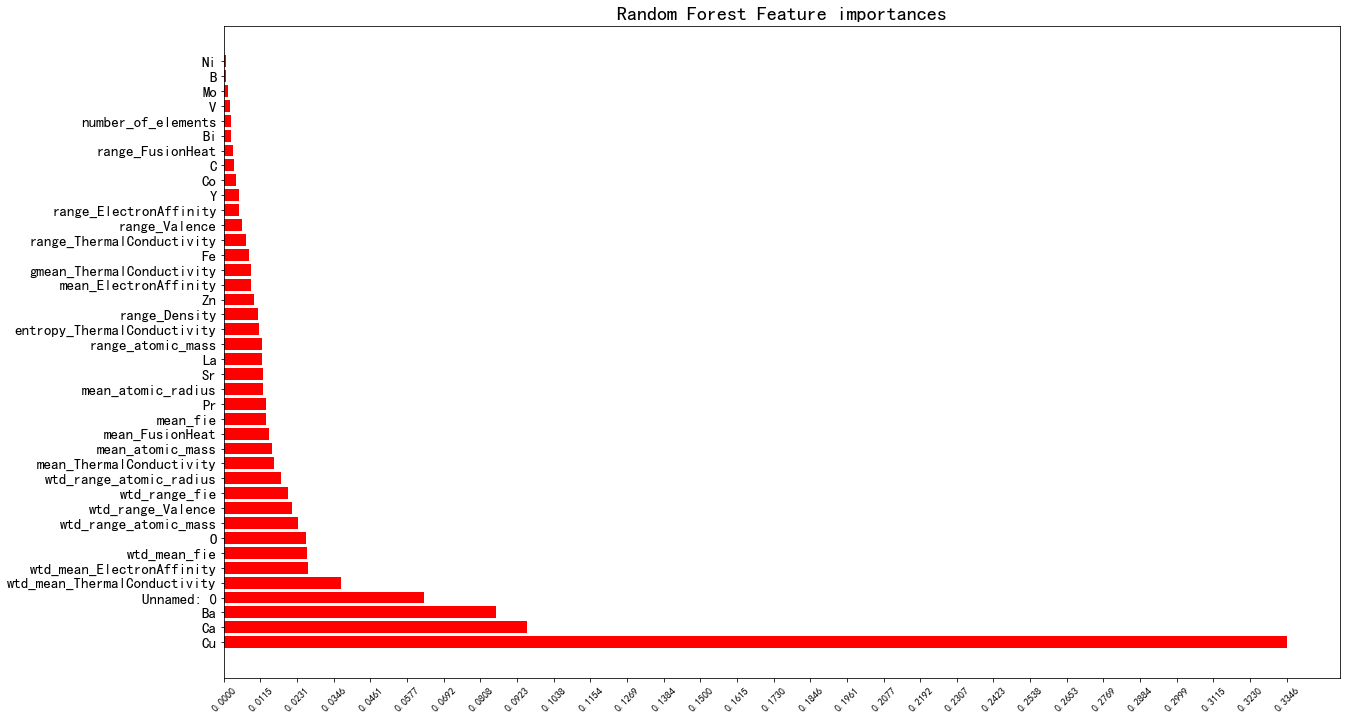

In [26]:
importances = ada.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
feature_importances = []
for f in range(x.shape[1]):
    if f == 40 : break
    print("%d. %s (%f)" % (f + 1, x.columns[indices[f]], importances[indices[f]]))
    feature_importances.append((x.columns[indices[f]],importances[indices[f]]))
    
# Print the feature ranking

values = [i[1] for i in feature_importances]
names = [i[0] for i in feature_importances]

# Plot the feature importances of the forest
plt.figure(figsize=(20,12))
plt.title("Random Forest Feature importances",fontsize=20)
plt.barh(range(len(names)),values, color="r", align='center') #, yerr=std[indices], align="center")
plt.yticks(range(len(names)),names,fontsize=15)
plt.xticks(np.linspace(0,max(importances),30),rotation=45)
plt.savefig('photos/regression/adaBoost_feature_importance.png')
plt.show()


In [27]:
# XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators = 2000, learning_rate = 0.05)
xgb.fit(x_train, y_train, early_stopping_rounds = 5,
       eval_set = [(x_test, y_test)], verbose = False)
y_prediction = pd.Series(xgb.predict(x_test))
y_prediction_train = pd.Series(xgb.predict(x_train))

MAE_LR = metrics.mean_absolute_error(y_test, y_prediction)
SQRT_LR = np.sqrt(metrics.mean_squared_error(y_test, y_prediction))
VARIENCE_LR = explained_variance_score(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)
# CC_LR=correlationCoefficient(y_test, y_pred,len(y_test) )

print('Root Mean Squared Error:',SQRT_LR )
print('Mean Absolute Error:', MAE_LR)  
print ('r2:',r2)
print('model score:', forest.score(x_train, y_train))

Root Mean Squared Error: 8.848059316605918
Mean Absolute Error: 5.241056212009876
r2: 0.9322978146749787
model score: 0.9899061727442358


Feature ranking:
1. Cu (0.573986)
2. Ba (0.076060)
3. range_ThermalConductivity (0.055016)
4. Ca (0.052028)
5. Zn (0.029350)
6. Pr (0.027274)
7. O (0.017227)
8. Fe (0.015879)
9. range_Valence (0.011085)
10. La (0.010059)
11. B (0.008956)
12. range_Density (0.007268)
13. range_FusionHeat (0.006455)
14. Sr (0.006293)
15. range_ElectronAffinity (0.005730)
16. Co (0.005452)
17. range_atomic_mass (0.004795)
18. mean_atomic_mass (0.004564)
19. wtd_mean_ThermalConductivity (0.004506)
20. Nb (0.004331)
21. wtd_mean_ElectronAffinity (0.003631)
22. mean_ThermalConductivity (0.003584)
23. mean_fie (0.003513)
24. Se (0.003436)
25. entropy_ThermalConductivity (0.003221)
26. P (0.003040)
27. wtd_range_Valence (0.002959)
28. mean_ElectronAffinity (0.002852)
29. Y (0.002779)
30. C (0.002694)
31. V (0.002682)
32. gmean_ThermalConductivity (0.002678)
33. Bi (0.002616)
34. mean_atomic_radius (0.002262)
35. wtd_range_fie (0.002253)
36. wtd_range_atomic_radius (0.002107)
37. Sb (0.002098)
38. mean_FusionHe

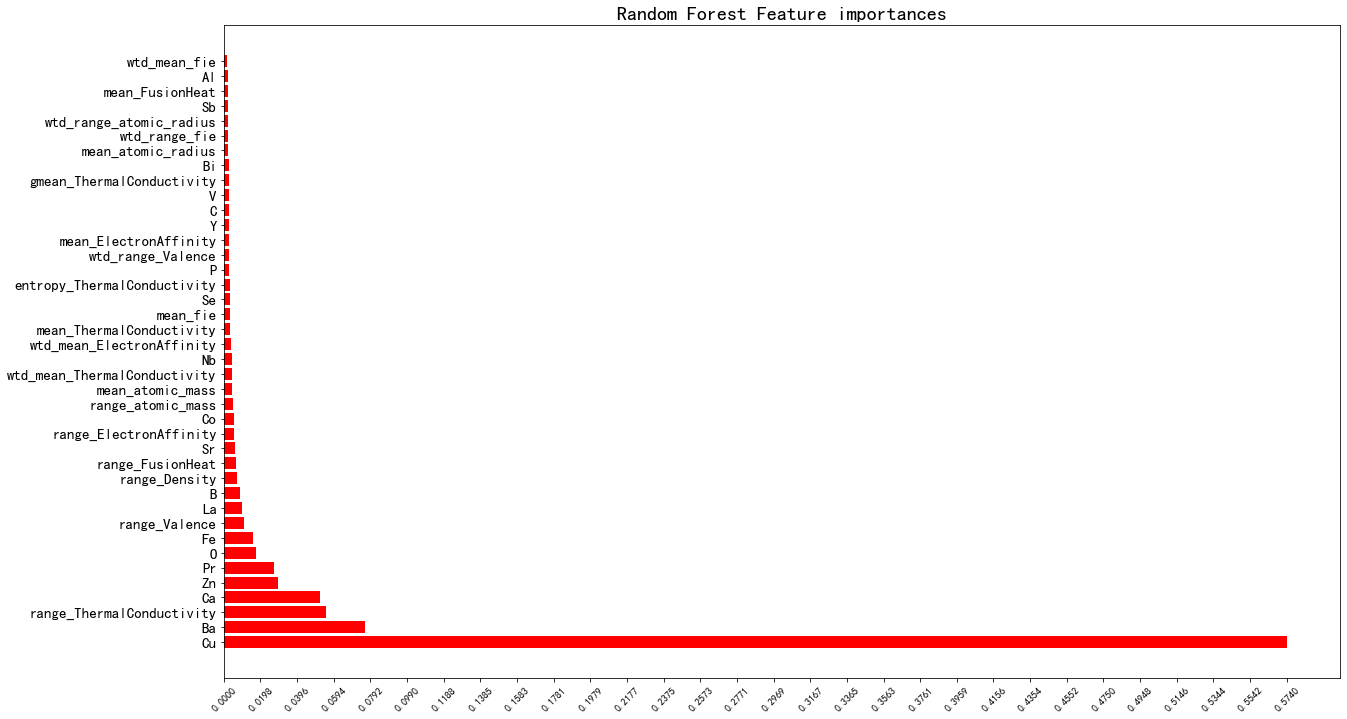

In [28]:
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
feature_importances = []
for f in range(x.shape[1]):
    if f == 40 : break
    print("%d. %s (%f)" % (f + 1, x.columns[indices[f]], importances[indices[f]]))
    feature_importances.append((x.columns[indices[f]],importances[indices[f]]))
    
# Print the feature ranking

values = [i[1] for i in feature_importances]
names = [i[0] for i in feature_importances]

# Plot the feature importances of the forest
plt.figure(figsize=(20,12))
plt.title("Random Forest Feature importances",fontsize=20)
plt.barh(range(len(names)),values, color="r", align='center') #, yerr=std[indices], align="center")
plt.yticks(range(len(names)),names,fontsize=15)
plt.xticks(np.linspace(0,max(importances),30),rotation=45)
plt.savefig('xgb_feature_importance.png')
plt.show()


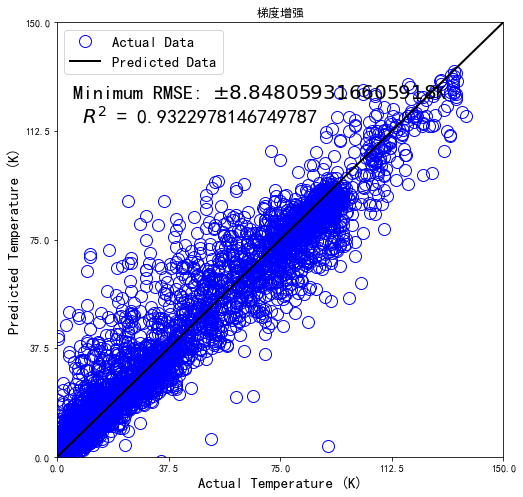

In [29]:
plt.figure(1, figsize=(8, 8))
plt.plot(y_test, y_prediction, 'bo', markersize = 12, mfc = 'none')
plt.plot([0, 150], [0, 150], 'k', linewidth = 2)
plt.xlabel('Actual Temperature (K)', fontsize = 15)
plt.ylabel('Predicted Temperature (K)', fontsize = 15)
plt.xlim((0, 150))
plt.ylim((0, 150))
ticks = np.linspace(0, 150, 5)
text = r'$\pm' + str(SQRT_LR) + '$' + 'K \n $R^2$ = ' + str(r2)
plt.text(5, 115, 'Minimum RMSE: ' + text, fontsize = 20)
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('梯度增强')
plt.legend(['Actual Data', 'Predicted Data'], loc = 'best', fontsize = 15)
plt.savefig('photos/regression/xgb.png')
plt.show()

In [30]:
# Bagging
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
bag = BaggingRegressor(base_estimator=tree, n_estimators=200, 
                       max_samples=1.0, max_features=1.0, bootstrap_features=False, n_jobs=1, random_state=1)
bag.fit(x_train, y_train)

y_prediction = pd.Series(bag.predict(x_test))
y_prediction_train = pd.Series(bag.predict(x_train))

# # 评价
MAE_LR = metrics.mean_absolute_error(y_test, y_prediction)
SQRT_LR = np.sqrt(metrics.mean_squared_error(y_test, y_prediction))
VARIENCE_LR = explained_variance_score(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)
# CC_LR=correlationCoefficient(y_test, y_pred,len(y_test) )

print('Root Mean Squared Error:',SQRT_LR )
print('Mean Absolute Error:', MAE_LR)  
print ('r2:',r2)
print('model score:', forest.score(x_train, y_train))

Root Mean Squared Error: 9.005178172617557
Mean Absolute Error: 4.911024694808127
r2: 0.9298720317938935
model score: 0.9899061727442358


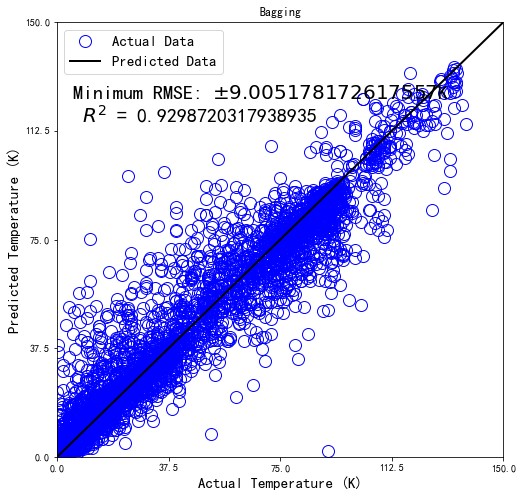

In [31]:
plt.figure(1, figsize=(8, 8))
plt.plot(y_test, y_prediction, 'bo', markersize = 12, mfc = 'none')
plt.plot([0, 150], [0, 150], 'k', linewidth = 2)
plt.xlabel('Actual Temperature (K)', fontsize = 15)
plt.ylabel('Predicted Temperature (K)', fontsize = 15)
plt.xlim((0, 150))
plt.ylim((0, 150))
ticks = np.linspace(0, 150, 5)
text = r'$\pm' + str(SQRT_LR) + '$' + 'K \n $R^2$ = ' + str(r2)
plt.text(5, 115, 'Minimum RMSE: ' + text, fontsize = 20)
plt.xticks(ticks)
plt.yticks(ticks)
plt.title('Bagging')
plt.legend(['Actual Data', 'Predicted Data'], loc = 'best', fontsize = 15)
plt.savefig('photos/regression/bagging.png')
plt.show()

In [32]:
# from sklearn.svm import LinearSVC
# # from sklearn import svm

# svm = LinearSVC()

# svm.fit(x_train, y_train.astype('int'))
# y_prediction = pd.Series(svm.predict(x_test))
# y_prediction_train = pd.Series(svm.predict(x_train))

# MAE_LR = metrics.mean_absolute_error(y_test, y_prediction)
# SQRT_LR = np.sqrt(metrics.mean_squared_error(y_test, y_prediction))
# VARIENCE_LR = explained_variance_score(y_test, y_prediction)
# r2 = r2_score(y_test, y_prediction)
# # CC_LR=correlationCoefficient(y_test, y_pred,len(y_test) )

# print('Root Mean Squared Error:',SQRT_LR )
# print('Mean Absolute Error:', MAE_LR)  
# print ('r2:',r2)
# print('model score:', svm.score(x_train, y_train))

In [33]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(x_train, y_train.astype('int'))
y_prediction = pd.Series(gnb.predict(x_test))
y_prediction_train = pd.Series(gnb.predict(x_train))

MAE_LR = metrics.mean_absolute_error(y_test, y_prediction)
SQRT_LR = np.sqrt(metrics.mean_squared_error(y_test, y_prediction))
VARIENCE_LR = explained_variance_score(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)
# CC_LR=correlationCoefficient(y_test, y_pred,len(y_test) )

print('Root Mean Squared Error:',SQRT_LR )
print('Mean Absolute Error:', MAE_LR)  
print ('r2:',r2)
print('model score:', forest.score(x_train, y_train))

Root Mean Squared Error: 38.61530653615761
Mean Absolute Error: 28.664361147479305
r2: -0.2895126587003829
model score: 0.9899061727442358


In [34]:
# stacking
from mlxtend.regressor import StackingRegressor
# 融合4个模型
stregr = StackingRegressor(regressors=[gnb, reg, xgb], meta_regressor=tree)

stregr.fit(x_train, y_train.astype('int'))
y_prediction = pd.Series(stregr.predict(x_test))
y_prediction_train = pd.Series(stregr.predict(x_train))

MAE_LR = metrics.mean_absolute_error(y_test, y_prediction)
SQRT_LR = np.sqrt(metrics.mean_squared_error(y_test, y_prediction))
VARIENCE_LR = explained_variance_score(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)
# CC_LR=correlationCoefficient(y_test, y_pred,len(y_test) )

print('Root Mean Squared Error:',SQRT_LR )
print('Mean Absolute Error:', MAE_LR)  
print ('r2:',r2)
print('model score:', forest.score(x_train, y_train))

Root Mean Squared Error: 9.328929132194169
Mean Absolute Error: 5.429496414597441
r2: 0.9247389584520209
model score: 0.9899061727442358


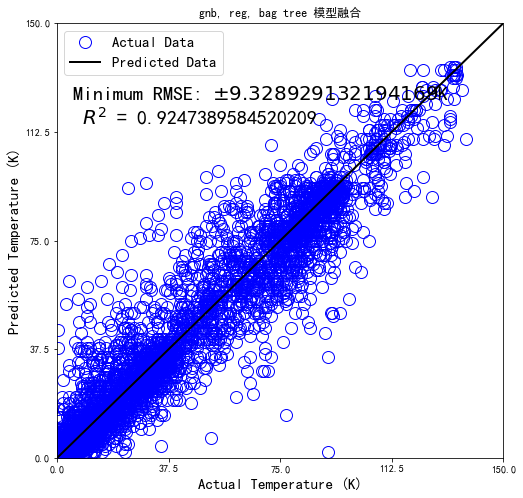

In [35]:
plt.figure(1, figsize=(8, 8))
plt.plot(y_test, y_prediction, 'bo', markersize = 12, mfc = 'none')
plt.plot([0, 150], [0, 150], 'k', linewidth = 2)
plt.xlabel('Actual Temperature (K)', fontsize = 15)
plt.ylabel('Predicted Temperature (K)', fontsize = 15)
plt.title('gnb, reg, bag tree 模型融合')
plt.xlim((0, 150))
plt.ylim((0, 150))
ticks = np.linspace(0, 150, 5)
text = r'$\pm' + str(SQRT_LR) + '$' + 'K \n $R^2$ = ' + str(r2)
plt.text(5, 115, 'Minimum RMSE: ' + text, fontsize = 20)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Actual Data', 'Predicted Data'], loc = 'best', fontsize = 15)
plt.savefig('photos/regression/stack.png')
plt.show()

c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\dell\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


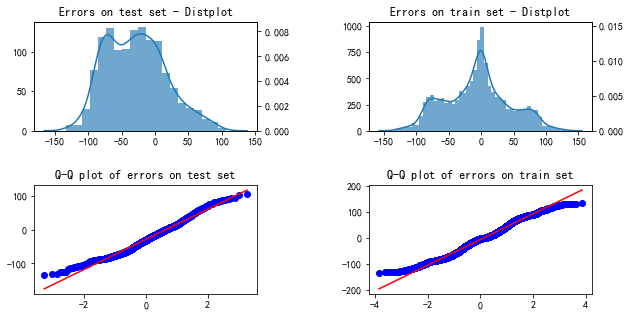

In [36]:
import seaborn as sns
from scipy.stats import norm
from scipy import stats


errors_test = (y_prediction - y_test).dropna()
errors_train = (y_prediction_train - y_train).dropna()

plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
plt.title('Errors on test set - Distplot')
ax_test = sns.distplot(errors_test, kde=False)
second_ax1 = ax_test.twinx()
sns.distplot(errors_test, ax=second_ax1, kde=True, hist=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,2)
plt.title('Errors on train set - Distplot')
ax_train = sns.distplot(errors_train, kde=False)
second_ax2 = ax_train.twinx()
sns.distplot(errors_train, ax=second_ax2, kde=True)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,3)
res = stats.probplot(errors_test, plot=plt)
plt.title('Q-Q plot of errors on test set')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2,2,4)
res = stats.probplot(errors_train, plot=plt)
plt.title('Q-Q plot of errors on train set')
plt.xlabel('')
plt.ylabel('')
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.savefig('GBoost_Errors_distplot.png')
plt.show()

In [37]:
from mlxtend.regressor import StackingCVRegressor
from mlxtend.data import boston_housing_data
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
# 初始化基模型
lr = LinearRegression()
svr_lin = SVR(kernel='linear', gamma='auto')
ridge = Ridge(random_state=2020,)
lasso =Lasso()
lg = LogisticRegression()
forest = RandomForestRegressor()
gbr = GradientBoostingRegressor()
tree = DecisionTreeRegressor()

models = [ridge, tree, gbr, lasso]

params = {'lasso__alpha': [0.1, 1.0, 10.0],
          'ridge__alpha': [0.1, 1.0, 10.0]}

sclf = StackingCVRegressor(regressors=models, meta_regressor=ridge)
grid = GridSearchCV(estimator=sclf, param_grid=params, cv=5, refit=True)
grid.fit(x_train, y_train)
print(grid.best_score_, grid.best_params_)


0.9018902449252442 {'lasso__alpha': 1.0, 'ridge__alpha': 1.0}
